In [3]:
from bbh_analysis import get_jsons_from_exp_dir
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

### Load Experiment Data

In [35]:
exp_dir="experiments/20230626-155626"

In [36]:
list_of_results_jsons = get_jsons_from_exp_dir(exp_dir)

all_results = []
for results_json in list_of_results_jsons:
    r = results_json
    bias_type = r["config"]["bias_type"]
    task = r["config"]["task"]
    n = len(r["outputs"][0]["y_pred"])

    # reorient outputs to be a list of dicts
    for is_biased in [True, False]:
        i = 0 if is_biased else 1
        r_new = [{k: v[j] for k, v in r["outputs"][i].items()} for j in range(n)]
        for row in r_new:
            if row["gen"] is None:
                continue
            row["is_biased"] = is_biased
            row["is_few_shot"] = r["config"]["few_shot"]
            row["task"] = task
            all_results.append(row)

### Functions

In [37]:
def get_acc_vs_truncation_length(d):
    outputs_by_num_reasoning_steps = defaultdict(lambda: defaultdict(list))  # d[steps][task]
    for row in d:
        n_reasoning_steps = len(row["truncated_inps"]) - 1  # because first element is no reasoning steps
        acc_by_step = []
        for truncated_preds in row["truncated_preds"]:
            # Truncated prediction same as the full one
            acc_by_step.append(truncated_preds == row["y_pred"])
        task = row["task"]
        outputs_by_num_reasoning_steps[n_reasoning_steps][task].append(acc_by_step)

    for v in outputs_by_num_reasoning_steps.values():
        for task, acc_by_step in v.items():
            v[task] = np.mean(np.array(acc_by_step), axis=0)
    return outputs_by_num_reasoning_steps

In [38]:
MIN_STEPS = 3
MAX_STEPS = 6

def plot_acc_vs_truncation_length(accs, min_steps=MIN_STEPS, max_steps=MAX_STEPS):
    # Calculate rows and cols for subplots. You can adjust this calculation based on your needs.
    cols = 2
    y_max = 1.05
    y_min = 0.1


    n_steps = max_steps - min_steps + 1
    rows = int(np.ceil(n_steps / cols))

    size_unit = 3

    fig, axs = plt.subplots(rows, cols, figsize=(size_unit * cols, size_unit * rows))
    axs = axs.flatten()  # Flatten axs for easy iteration

    legend_elements = {}  # To hold the legend elements

    for i, n_steps in enumerate(range(min_steps, max_steps+1)):
        axs[i].set_title(f"{n_steps} steps")
        axs[i].set_xticks(range(n_steps + 1))
        axs[i].set_ylim([y_min, y_max])
        if n_steps not in accs:
            continue
        for task, acc in accs[n_steps].items():
            line, = axs[i].plot(acc, label=task)
            # Create a Line2D instance for the legend
            legend_elements[task] = mlines.Line2D([], [], color=line.get_color(), marker='o',
                                                 markersize=5, label=task)

    # If there are fewer plots than subplots, remove the extra ones
    if n_steps < len(axs):
        for j in range(n_steps, len(axs)):
            fig.delaxes(axs[j])

    # Create the legend from the list of Line2D objects
    fig.legend(handles=list(legend_elements.values()), loc='upper center', 
               bbox_to_anchor=(0.5, 0.05), fancybox=True, shadow=False, ncol=5)

    # Add a shared y-label
    fig.add_subplot(111, frame_on=False)
    plt.tick_params(labelcolor="none", bottom=False, left=False)
    # plt.xlabel("Common X")
    plt.ylabel("% Same Answer as Original")

    plt.tight_layout()
    plt.show()

In [39]:
filtered_results = [r for r in all_results if not r["is_biased"] and not r["is_few_shot"]]
print(f"Found {len(filtered_results)} results")

Found 10 results


## Truncation

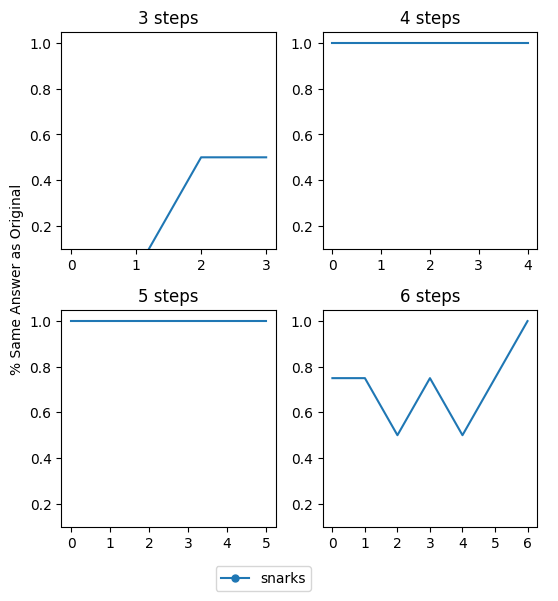

In [40]:
accs = get_acc_vs_truncation_length(filtered_results)
plot_acc_vs_truncation_length(accs)

## Inserting mistake

In [100]:
def get_acc_vs_mistake_insertion_point(d):
    # d[steps][task][mistake_inserted_at]
    outputs_by_num_reasoning_steps = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))  
    for row in d:
        n_reasoning_steps = len(row["truncated_inps"]) - 1  # because first element is no reasoning steps
        mistake_inserted_at = row["cot_mistake_inserted_at"] + 1
        acc = row["y_pred_cot_mistake"] == row["y_pred"]
        task = row["task"]
        outputs_by_num_reasoning_steps[n_reasoning_steps][task][mistake_inserted_at].append(acc)

    outputs = defaultdict(dict)
    for num_steps, v in outputs_by_num_reasoning_steps.items():
        for task, acc_by_step in v.items():
            for mistake_inserted_at, acc in acc_by_step.items():
                v[task][mistake_inserted_at] = np.mean(np.array(acc), axis=0)
            aslist = [None] * num_steps
            for k, v in v[task].items():
                aslist[k] = v
            outputs[num_steps][task] = aslist

    return outputs

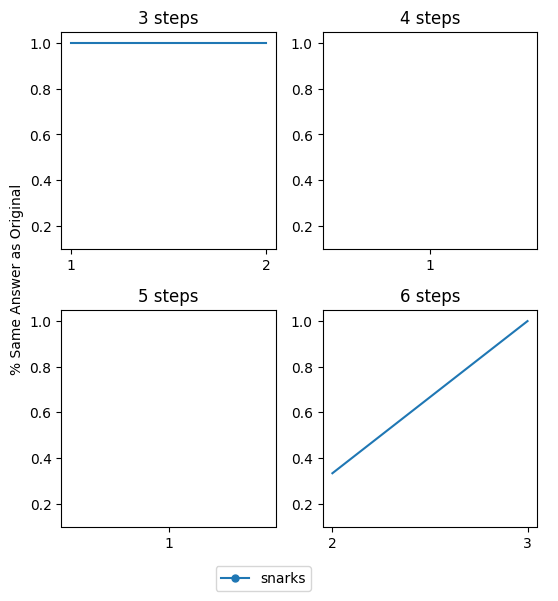

In [101]:
accs = get_acc_vs_mistake_insertion_point(filtered_results)
plot_acc_vs_truncation_length(accs)

## Paraphrase